# 📌 Extracão

In [ ]:

# Importando pandas
import pandas as pd

#Buscando a base de dados
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
df = pd.read_json(url)

df.head()

In [ ]:
df.info()

In [ ]:
df_customer = pd.json_normalize(df['customer'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])
df_phone = pd.json_normalize(df['phone'])

df_main = df[['customerID', 'Churn']]

df_final = pd.concat([df_main, df_customer, df_phone, df_internet, df_account], axis=1)

In [ ]:
df_final.head()

In [ ]:
df_final.info()

In [ ]:
print('INFORMAÇÕES DA BASE DE DADOS')
print(f'Nº Linhas: {df_final.shape[0]}')
print(f'Nº Colunas: {df_final.shape[1]}')

In [ ]:
df_final.to_csv('TelecomX_Dados.csv', index=False)

# 🔧 Transformação

In [215]:
# Importando pandas
import pandas as pd

df_base = pd.read_csv('TelecomX_Dados.csv')

In [216]:
# Normalizando nomes das colunas
df_base.columns = df_base.columns.str.lower()

# Traduzindo nomes das colunas
# A tradução é feita para facilitar a compreensão, mas pode ser ajustada conforme necessário
traducao_colunas = {
    'customerid': 'id_cliente',
    'gender': 'genero',
    'seniorcitizen': 'idoso',
    'partner': 'tem_conjuge',
    'dependents': 'dependentes',
    'tenure': 'tempo_de_contrato',
    'phoneservice': 'servico_telefone',
    'multiplelines': 'multiplas_linhas',
    'internetservice': 'servico_internet',
    'onlinesecurity': 'seguranca_online',
    'onlinebackup': 'backup_online',
    'deviceprotection': 'protecao_aparelho',
    'techsupport': 'suporte_tecnico',
    'streamingtv': 'tv_streaming',
    'streamingmovies': 'filmes_streaming',
    'contract': 'contrato',
    'paperlessbilling': 'fatura_digital',
    'paymentmethod': 'metodo_pagamento',
    'charges.monthly': 'cobranca_mensal',
    'charges.total': 'cobranca_total'
}
df_base.rename(columns=traducao_colunas, inplace=True)

traducao_contratos = {
    'One year': 'anual',
    'Month-to-month': 'mensal',
    'Two year': 'bianual'
}
df_base['contrato'] = df_base['contrato'].replace(traducao_contratos)

traducao_pagamentos = {
    'Mailed check': 'Cheque enviado pelo correio',
    'Electronic check': 'Cheque eletronico',
    'Credit card (automatic)': 'Cartao de crédito (automatico)',
    'Bank transfer (automatic)': 'Transferencia bancaria (automatica)'
}
df_base['metodo_pagamento'] = df_base['metodo_pagamento'].replace(traducao_pagamentos)

traducao_internet = {
    'DSL': 'DSL',
    'Fiber optic': 'Fibra optica',
    'No': 'Sem servico de internet'
}
df_base['servico_internet'] = df_base['servico_internet'].replace(traducao_internet)

traducao_genero = {
    'Female': 'Feminino',
    'Male': 'Masculino'
}
df_base['genero'] = df_base['genero'].replace(traducao_genero)

In [217]:
# Removendo linhas duplicadas
linhas_duplicadas = df_base[df_base.duplicated()]
percentual_linhas_duplicadas = (len(linhas_duplicadas) / df_base.shape[0]) * 100
print(f"Número de linhas duplicadas: {len(linhas_duplicadas)} - {percentual_linhas_duplicadas:.2f}%")
df_base = df_base.drop_duplicates()

# Conversão de tipo
df_base['cobranca_total'] = pd.to_numeric(df_base['cobranca_total'], errors='coerce')

# Verificando valor nulos
linhas_com_nulo = df_base[df_base.isnull().any(axis=1)]
percentual_linhas_nulas = (len(linhas_com_nulo) / df_base.shape[0]) * 100
print(f"Número de linhas com algum valor nulo: {len(linhas_com_nulo)} - {percentual_linhas_nulas:.2f}%")

df_base = df_base.dropna()

# Normalizando colunas de binárias
colunas_yes_no = ['churn','tem_conjuge','dependentes','servico_telefone','fatura_digital']
df_base[colunas_yes_no] = df_base[colunas_yes_no].apply(lambda x: x.str.lower())
df_base[colunas_yes_no] = df_base[colunas_yes_no].replace({'yes': 1, 'no': 0})
df_base[colunas_yes_no] = df_base[colunas_yes_no].apply(lambda x: x.astype(int))

Número de linhas duplicadas: 0 - 0.00%
Número de linhas com algum valor nulo: 235 - 3.23%


In [235]:
df_base['cobranca_diaria'] = df_base['cobranca_mensal'] / 30

In [219]:
print(f'TOTAL DE LINHAS: {df_base.shape[0]}')
print(f'TOTAL DE COLUNAS: {df_base.shape[1]}')

TOTAL DE LINHAS: 7032
TOTAL DE COLUNAS: 22


# 📊 Carga e análise

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

import matplotlib.pyplot as plt
import pandas as pd

In [221]:
def plot_pizza_churn(df_base, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda):
    """
    Plota um gráfico de pizza e um gráfico de barras para a coluna especificada.
    """
    # Definindo ordem desejada e cores associadas
    tipos = df_base[coluna].unique()

    # Dados para gráfico de pizza (distribuição de gênero)
    counts = df_base[coluna].value_counts().sort_values()
    counts = counts.reindex(tipos)

    # Dados para gráfico de barras (churn por gênero em %)
    churn = (
        df_base
        .groupby(['churn', coluna])
        .size()
        .groupby(level=0)
        .apply(lambda x: 100 * x / x.sum())
        .unstack(coluna) 
    )

    churn.index = churn.index.droplevel(0)
    churn.index = churn.index.map({0: 'Não churn', 1: 'Churn'})
    churn.columns.name = None
    churn = churn[tipos]

    # Criação do gráfico
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    churn.plot(kind='bar', stacked=False, ax=axs[1], color=cores)

    # Gráfico de pizza
    axs[0].pie(counts, labels=counts.index, autopct='%1.1f%%', colors=cores, startangle=90)
    axs[0].set_title(titulo_pizza, fontsize=14)
    axs[0].axis('equal')

    # Título e eixos
    axs[1].set_title(titulo_barras, fontsize=14)
    axs[1].set_ylabel('Percentual (%)')
    axs[1].set_xlabel('')  # Remove xlabel para evitar duplicação

    # Ajuste visual: remove eixo Y, grid e bordas
    axs[1].get_yaxis().set_visible(False)
    axs[1].grid(False)
    for spine in ['top', 'right', 'left']:
        axs[1].spines[spine].set_visible(False)
    axs[1].tick_params(axis='x', rotation=0)

    # Adicionar valor nas barras
    for container in axs[1].containers:
        axs[1].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    axs[1].legend(
        by_label.values(),
        by_label.keys(),
        title=titulo_legenda,
        bbox_to_anchor=(0.98, 0.98)
    )

    plt.tight_layout()
    plt.show()

def plot_barra_churn(df_base, coluna, cores, titulo_barra1, titulo_barra2, titulo_legenda):
    """
    Plota um gráfico de pizza e um gráfico de barras para a coluna especificada.
    """
    # Definindo ordem desejada e cores associadas
    tipos = df_base[coluna].unique()

    # Dados para gráfico de pizza (distribuição de gênero)
    counts = df_base[coluna].value_counts(normalize=True).sort_values()
    counts = counts.reindex(tipos)
    counts = counts.to_frame().T
    counts.values[0] = counts.values[0]*100
    counts = counts.sort_values(by=counts.index[0], axis=1, ascending=False)
    counts = counts.rename(index={'proportion': titulo_legenda})

    # Dados para gráfico de barras (churn por gênero em %)
    churn = (
        df_base
        .groupby(['churn', coluna])
        .size()
        .groupby(level=0)
        .apply(lambda x: 100 * x / x.sum())
        .unstack(coluna) 
    )

    churn.index = churn.index.droplevel(0)
    churn.index = churn.index.map({0: 'Não churn', 1: 'Churn'})
    churn.columns.name = None
    churn = churn[tipos]

    # Criação do gráfico
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    counts.plot(kind='bar', stacked=False, ax=axs[0], color=cores)

    axs[0].set_title(titulo_barra1, fontsize=14)
    axs[0].set_ylabel('Percentual (%)')
    axs[0].set_xlabel('') 
    axs[0].get_yaxis().set_visible(False)
    axs[0].grid(False)
    axs[0].tick_params(axis='x', rotation=0)

    for spine in ['top', 'right', 'left']:
        axs[0].spines[spine].set_visible(False)
    

    # Adicionar valor nas barras
    for container in axs[0].containers:
        axs[0].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

    if axs[0].get_legend():
        axs[0].get_legend().remove()


    churn.plot(kind='bar', stacked=False, ax=axs[1], color=cores)

    axs[1].set_title(titulo_barra2, fontsize=14)
    axs[1].set_ylabel('Percentual (%)')
    axs[1].set_xlabel('')  
    axs[1].get_yaxis().set_visible(False)
    axs[1].grid(False)
    axs[1].tick_params(axis='x', rotation=0)

    for spine in ['top', 'right', 'left']:
        axs[1].spines[spine].set_visible(False)

    for container in axs[1].containers:
        axs[1].bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=9)

    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    axs[1].legend(
        by_label.values(),
        by_label.keys(),
        title=titulo_legenda,
        bbox_to_anchor=(0.98, 0.98)
    )

    plt.tight_layout()
    plt.show()

def plot_boxplot(df_base, x, y, titulo, label, cores):
    plt.figure(figsize=(8, 5))

    # Desenha o boxplot primeiro
    sns.boxplot(
        x=x,
        y=y,
        hue='churn',
        data=df_base,
        palette=cores,
        linewidth=1.5,
        fliersize=4,
        boxprops=dict(alpha=0.8),
        legend=False
    )

    # Calcula os valores
    medias = df_base.groupby('churn')[y].mean()
    medianas = df_base.groupby('churn')[y].median()

    # Agora os marcadores vêm por cima!
    for i in range(2):  # churn: 0 ou 1
        plt.scatter(i, medias[i], color='black', marker='D', s=40, zorder=5, label='Média' if i == 0 else "")

    # Título e rótulos
    plt.title(titulo, fontsize=14, weight='bold')
    plt.xlabel('')
    plt.ylabel(label, fontsize=12)
    plt.xticks([0, 1], ['Não Churn', 'Churn'], fontsize=11)

    sns.despine()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()



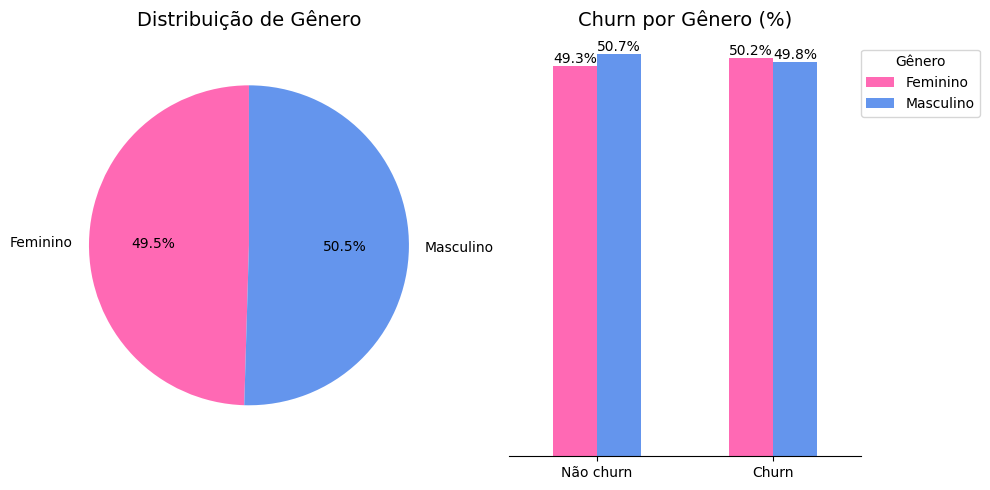

In [222]:
cores = ['#FF69B4', '#6495ED']

titulo_barras = 'Churn por Gênero (%)'
titulo_pizza = 'Distribuição de Gênero'
titulo_legenda = 'Gênero'
coluna = 'genero'

plot_pizza_churn(df_base, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)

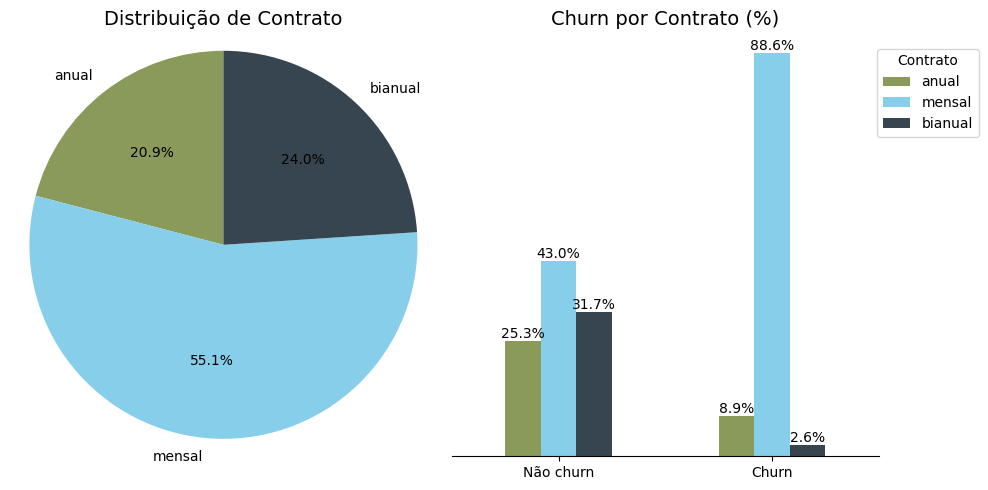

In [223]:
cores = ['#8A9A5B', '#87CEEB','#36454F' ]

titulo_barras = 'Churn por Contrato (%)'
titulo_pizza = 'Distribuição de Contrato'
titulo_legenda = 'Contrato'
coluna = 'contrato'

plot_pizza_churn(df_base, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)

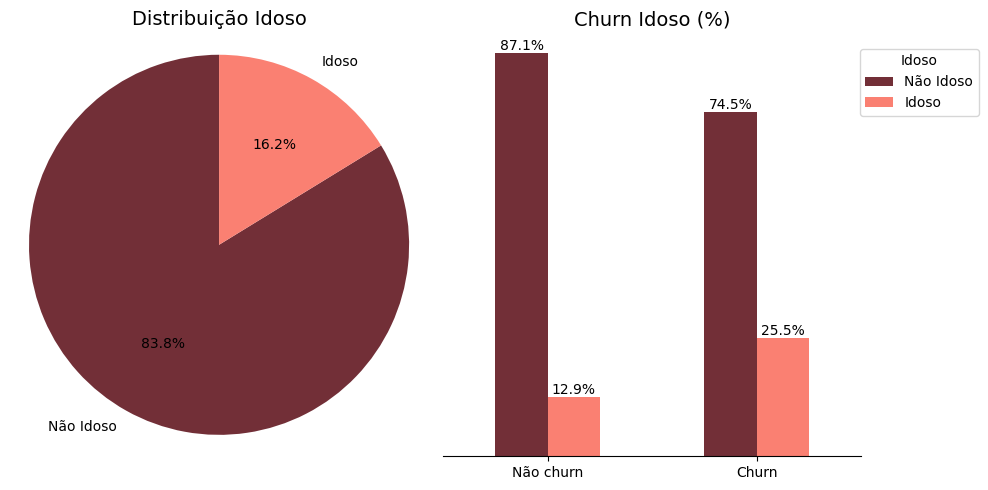

In [224]:
cores = ['#722F37', '#FA8072']

titulo_barras = 'Churn Idoso (%)'
titulo_pizza = 'Distribuição Idoso'
titulo_legenda = 'Idoso'
coluna = 'idoso'

df = df_base.copy()
df[coluna].replace({0: 'Não Idoso', 1: 'Idoso'}, inplace=True)

plot_pizza_churn(df, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)


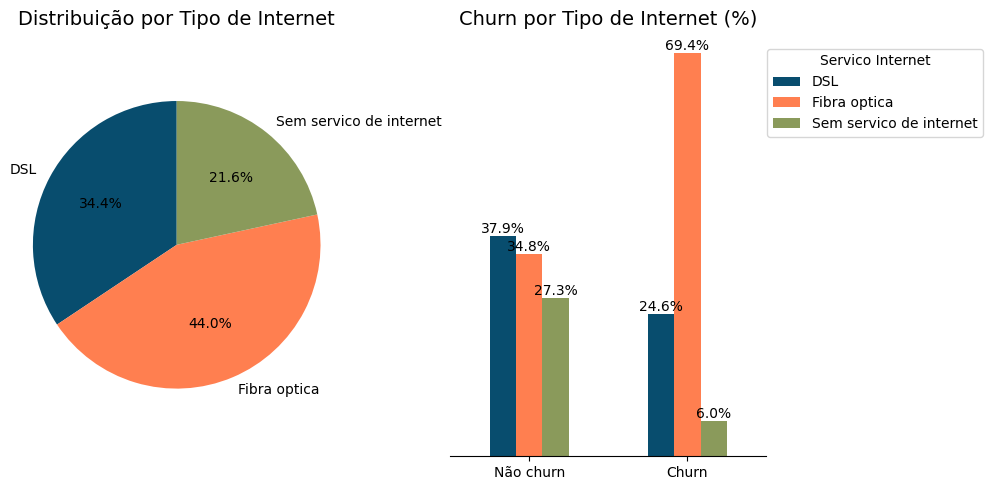

In [225]:
cores = ['#084D6E', '#FF7F50', '#8A9A5B']  

titulo_barras = 'Churn por Tipo de Internet (%)'
titulo_pizza = 'Distribuição por Tipo de Internet'
titulo_legenda = 'Servico Internet'
coluna = 'servico_internet'

plot_pizza_churn(df_base, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)

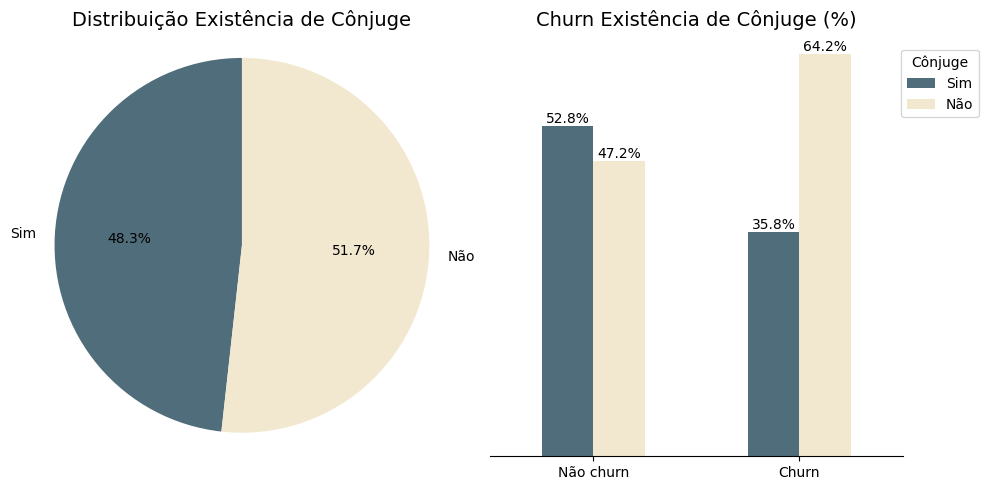

In [226]:
cores = ['#4F6D7A', '#F2E8CF']  

titulo_barras = 'Churn Existência de Cônjuge (%)'
titulo_pizza = 'Distribuição Existência de Cônjuge'
titulo_legenda = 'Cônjuge'
coluna = 'tem_conjuge'

df = df_base.copy()
df[coluna].replace({0: 'Não', 1: 'Sim'}, inplace=True)

plot_pizza_churn(df, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)

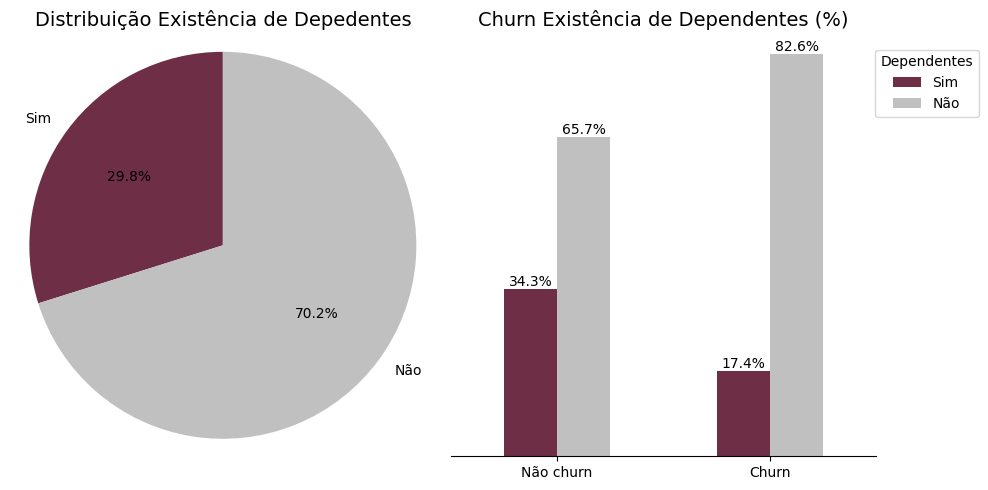

In [227]:
cores = [ '#6D2E46', '#C0C0C0' ]

titulo_barras = 'Churn Existência de Dependentes (%)'
titulo_pizza = 'Distribuição Existência de Depedentes'
titulo_legenda = 'Dependentes'
coluna = 'dependentes'

df = df_base.copy()
df[coluna].replace({0: 'Não', 1: 'Sim'}, inplace=True)

plot_pizza_churn(df, coluna, cores, titulo_pizza, titulo_barras, titulo_legenda)

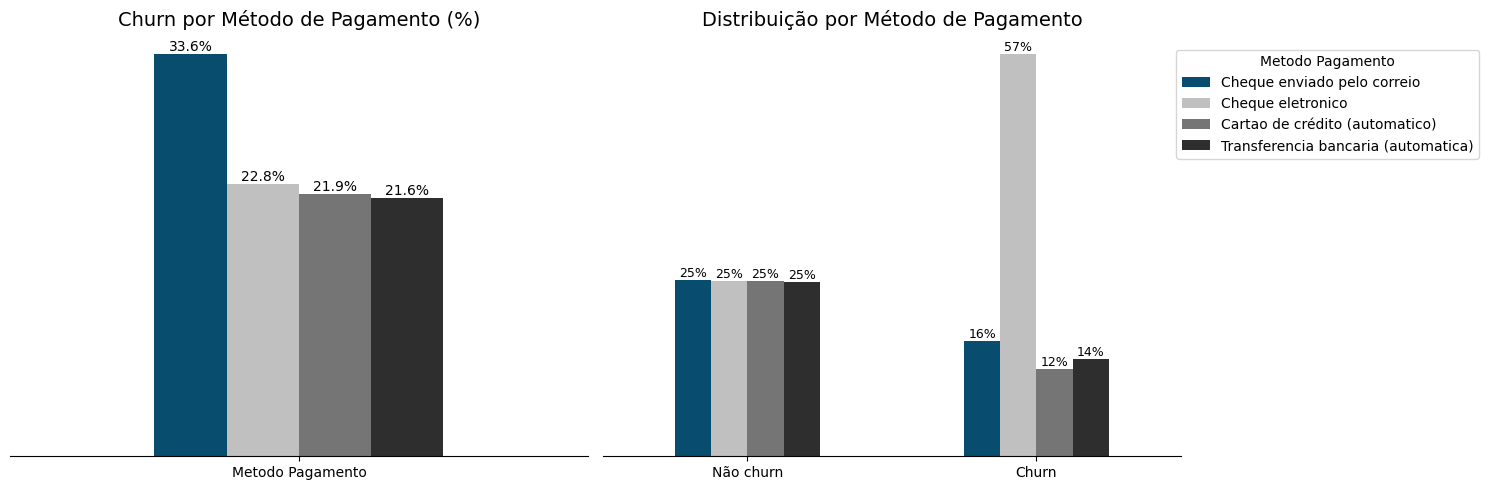

In [228]:
cores = [ '#084D6E', '#C0C0C0', '#757575','#2E2E2E' ]

titulo_churn = 'Churn por Método de Pagamento (%)'
titulo_barra = 'Distribuição por Método de Pagamento'
titulo_legenda = 'Metodo Pagamento'
coluna = 'metodo_pagamento'

plot_barra_churn(df_base, coluna, cores, titulo_churn, titulo_barra, titulo_legenda)

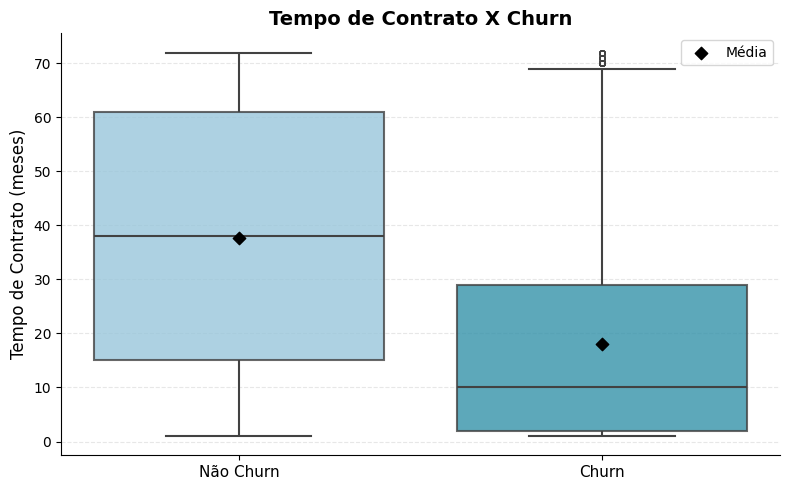

In [229]:
cores = ['#8ECAE6', '#219EBC']

x = 'churn'
y = 'tempo_de_contrato'
titulo = 'Tempo de Contrato X Churn'
label = 'Tempo de Contrato (meses)'

plot_boxplot(df_base, x, y, titulo, label, cores)

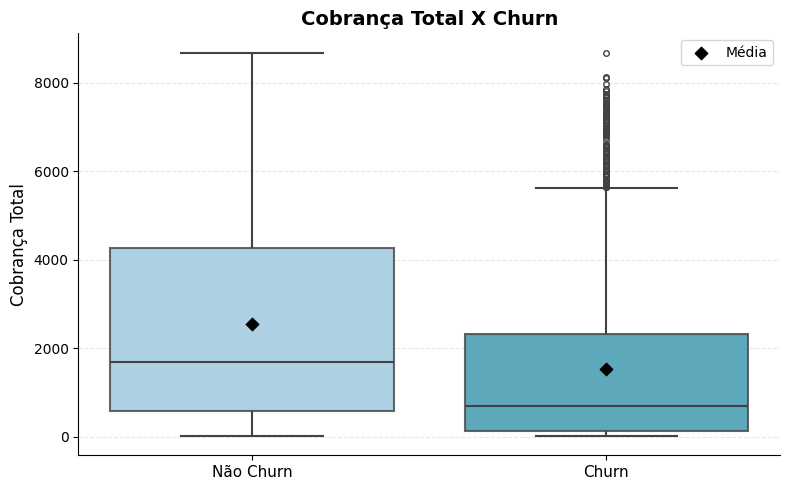

In [230]:
cores = ['#8ECAE6', '#219EBC']

x = 'churn'
y = 'cobranca_total'
titulo = 'Cobrança Total X Churn'
label = 'Cobrança Total'

plot_boxplot(df_base, x, y, titulo, label, cores)

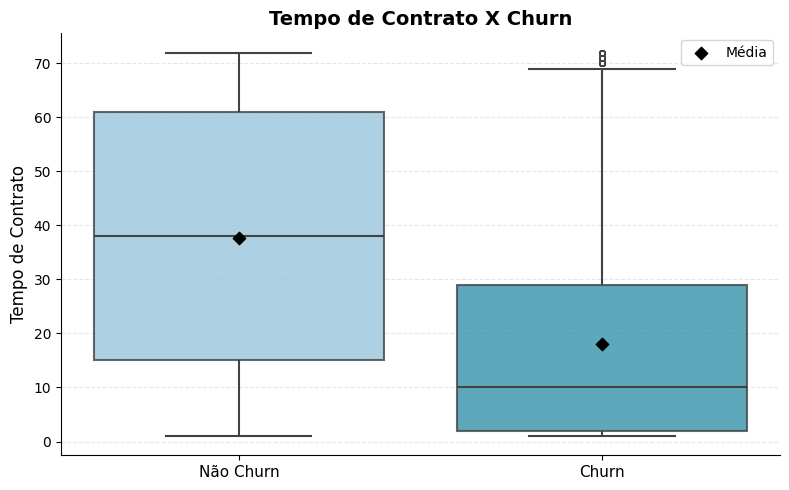

In [231]:
cores = ['#8ECAE6', '#219EBC']

x = 'churn'
y = 'tempo_de_contrato'
titulo = 'Tempo de Contrato X Churn'
label = 'Tempo de Contrato'

plot_boxplot(df_base, x, y, titulo, label, cores)

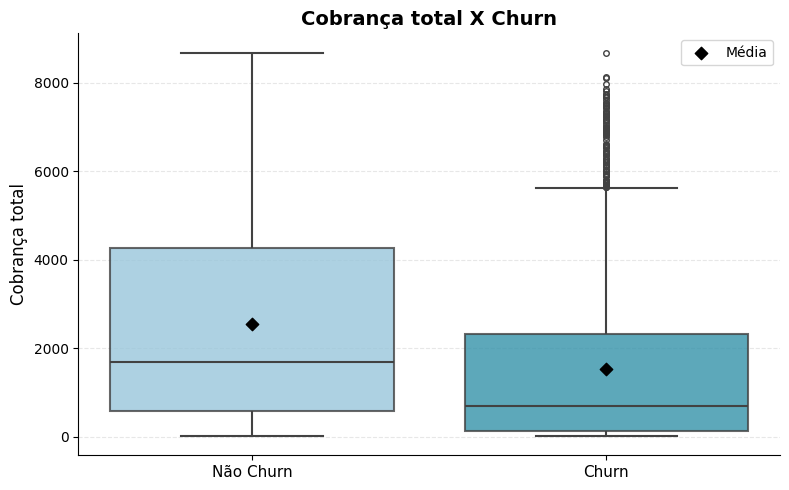

In [245]:
cores = ['#8ECAE6', '#219EBC']

x = 'churn'
y = 'cobranca_total'
titulo = 'Cobrança total X Churn'
label = 'Cobrança total'

plot_boxplot(df_base, x, y, titulo, label, cores)

# 📄Relatorio Final

A evasão de clientes — conhecida como churn — representa um dos maiores obstáculos para empresas de telecomunicações, impactando diretamente a sustentabilidade do negócio. Este estudo tem como foco a análise dos padrões de cancelamento de clientes da TelecomX a partir de dados reais. Ao compreender as variáveis que influenciam o churn, a empresa poderá desenvolver estratégias mais eficazes de retenção, melhorar a experiência do usuário e minimizar perdas financeiras.

## Limpeza e Tratamento de Dados

**Padronização de Colunas**
- Todas as colunas foram convertidas para letras minúsculas.
- Os nomes técnicos foram traduzidos para português, com o objetivo de facilitar a interpretação e análise dos dados.

**Tratamento de Valores Categóricos**
- Tradução dos valores nas colunas:
  - `contrato`: 'Month-to-month', 'One year', 'Two year' → 'mensal', 'anual', 'bianual'.
  - `metodo_pagamento`: tradução de métodos como 'Electronic check', 'Mailed check', etc.
  - `servico_internet`: tradução de 'DSL', 'Fiber optic', 'No'.
  - `genero`: 'Male', 'Female' → 'Masculino', 'Feminino'.

**Remoção de Dados Duplicados e Nulos**
- Identificação e remoção de linhas duplicadas.
- Conversão da coluna `cobranca_total` para tipo numérico com tratamento de erros.
- Detecção de valores nulos e exclusão de registros incompletos.

**Normalização de Variáveis Binárias**
- Colunas como `churn`, `tem_conjuge`, `dependentes`, `servico_telefone` e `fatura_digital` foram convertidas:
  - Texto em minúsculo: 'yes' / 'no' → 'yes' / 'no'.
  - Transformação em variáveis binárias numéricas: 1 para “sim”, 0 para “não”.

## Análise 

Durante a análise exploratória, foram utilizados gráficos de pizza, barras e boxplots para investigar os principais fatores relacionados ao churn (evasão) dos clientes da TelecomX. As visualizações permitiram identificar padrões relevantes:

- ***Gênero:*** A distribuição entre masculino e feminino é equilibrada, e o churn não apresenta diferença significativa entre os gêneros.  
- ***Contrato:*** Clientes com contrato mensal apresentam taxas de churn muito superiores aos contratos anual e bianual, indicando maior risco de evasão nesse grupo.  
- **Idosos:** A proporção de churn é maior entre clientes idosos, sugerindo que esse público pode demandar atenção especial.
- **Tipo de Internet:** Clientes sem serviço de internet têm menor churn, enquanto usuários de fibra óptica apresentam taxas mais elevadas.  
- **Cônjuge e Dependentes:** Clientes sem cônjuge ou dependentes tendem a apresentar maior churn.  
- **Método de Pagamento:** Métodos como cheque eletrônico estão associados a maior churn, enquanto transferência bancária automática apresenta menor evasão.  
- **Tempo de Contrato e Cobrança Total:** Boxplots mostram que clientes com menor tempo de contrato e menor cobrança total têm maior propensão ao churn.

## Conclusões e Insights

- `Cobrança mensal` são o principal fator de risco para churn. Estratégias de retenção devem focar nesse grupo.
- Clientes `idosos` e sem vínculos familiares (`cônjuge` e/ou `dependentes`) estão mais propensos a cancelar.
- `Métodos de pagamento` automáticos (transferência bancária) reduzem a evasão.
- Menor `tempo de contrato` e baixa cobrança total indicam clientes menos engajados, com maior chance de churn.
- `Tipo de serviço de internet` influencia a evasão, especialmente para fibra óptica.

## Recomendações

- Oferecer benefícios para contratos de longo prazo: Incentive a migração de clientes mensais para planos anual/bianual com descontos ou vantagens.
- Criar campanhas de retenção para idosos: Desenvolver atendimento personalizado e benefícios para esse público.
- Facilitar métodos de pagamento automáticos: Promover a adesão à transferência bancária automática, reduzindo o churn.
- Aumentar o engajamento de novos clientes: Oferecer onboarding, suporte e benefícios nos primeiros meses para aumentar o tempo de contrato.
- Personalizar ofertas para clientes sem vínculos familiares: Identificar e oferecer vantagens específicas para clientes sem cônjuge ou dependentes.
- Monitorar clientes de fibra óptica: Investigar causas de insatisfação e promover melhorias nesse serviço.

# Correlação entre as variáveis